# Dataset

In [1]:
import os
import tarfile
from mxnet import gluon

data_root = '../data'
voc_root = data_root + '/VOCdevkit/VOC2012'
url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
       '/VOCtrainval_11-May-2012.tar')
sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'

fname = gluon.utils.download(url, data_root, sha1_hash = sha1)

if not os.path.isfile(voc_root + '/ImageSets/Segmentation/train.txt'):
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_root)

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
from mxnet import image

def read_images(root = voc_root, train = True):
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

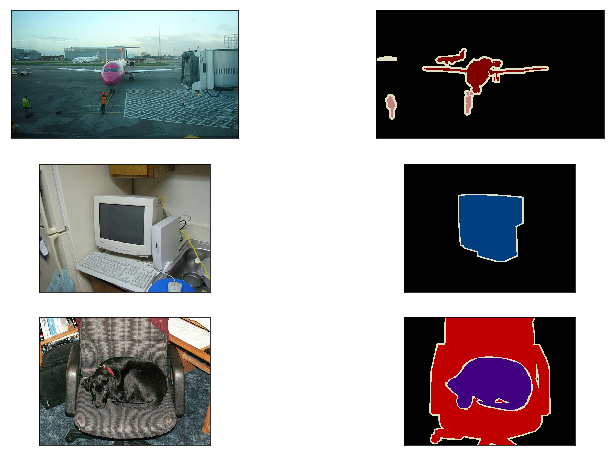

[(281, 500, 3),
 (281, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3)]

In [3]:
import sys
sys.path.append('..')
import utils

train_images, train_labels = read_images()

imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]

utils.show_images(imgs, nrows = 3, ncols = 2, figsize = (12,8))
[im.shape for im in imgs]

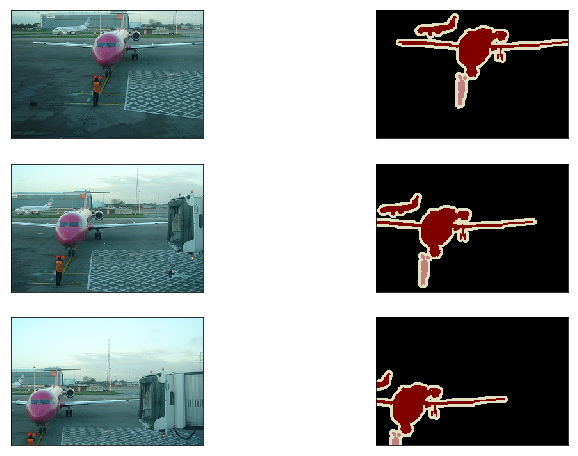

In [4]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0], 
                      200, 300)
    
utils.show_images(imgs, nrows = 3, ncols = 2, figsize = (12, 8))

In [5]:
classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 
           'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 
           'dog', 'horse', 'motorbike', 'person', 'potted plant', 
           'sheep', 'sofa', 'train', 'tv/monitor']
# RGB color for each class
colormap = [[0,0,0], [128,0,0], [0,128,0],  [128,128,0], [0,0,128],
            [128,0,128], [0,128,128], [128,128,128], [64,0,0], [192,0,0],
            [64,128,0], [192,128,0], [64,0,128], [192,0,128],
            [64,128,128], [192,128,128], [0,64,0], [128,64,0],
            [0,192,0], [128,192,0], [0,64,128]]

len(classes), len(colormap)

(21, 21)

In [6]:
import numpy as np
from mxnet import nd

cm2lbl = np.zeros(256 ** 3)
for i, cm in enumerate(colormap):
    cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
    
def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0] * 256 + data[:,:,1]) * 256 + data[:,:,2]
    return nd.array(cm2lbl[idx])

In [7]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]]
<NDArray 10x10 @cpu(0)>

In [8]:
from mxnet import gluon
from mxnet import nd

rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):
    
    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and 
            im.shape[1] >= self.crop_size[1])]
    
    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        data, label = read_images(train = train)
        data = self._filter(data)
        self.data = [normalize_image(im) for im in data]
        self.label = self._filter(label)
        print('Read ' + str(len(self.data)) + 'examples')
        
    def __getitem__(self, idx):
        data, label = rand_crop(
            self.data[idx], self.label[idx], 
            *self.crop_size)
        data = data.transpose((2, 0, 1)).astype('float32')
        label = image2label(label)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [9]:
# height x width
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

Read 1114examples
Read 1078examples


In [10]:
batch_size = 64
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle = True, last_batch = 'discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size, last_batch = 'discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


# Fully Connect Network

In [11]:
from mxnet.gluon import nn
conv = nn.Conv2D(10, kernel_size = 4, padding = 1, strides = 2)
conv_trans = nn.Conv2DTranspose(3, kernel_size = 4, padding = 1, strides = 2)

conv.initialize()
conv_trans.initialize()

x = nd.random.uniform(shape = (1, 3, 64, 64))
y = conv(x)
print('Input:', x.shape)
print('After conv:', y.shape)
print('After transposed conv', conv_trans(y).shape)

Input: (1, 3, 64, 64)
After conv: (1, 10, 32, 32)
After transposed conv (1, 3, 64, 64)


In [12]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained = True)

pretrained_net.classifier
# (pretrained_net.features, pretrained_net.classifier)

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
  (1): Activation(relu)
  (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
  (3): Flatten
  (4): Dense(512 -> 1000, linear)
)

In [13]:
net = nn.HybridSequential()
for layer in pretrained_net.features:
    net.add(layer)
for layer in pretrained_net.classifier[:-3]:
    net.add(layer)
x = nd.random.uniform(shape=(1, 3, *input_shape))
print('Input:', x.shape)
print('Output:', net(x).shape)

Input: (1, 3, 320, 480)
Output: (1, 512, 10, 15)


In [14]:
num_classes = len(classes)

with net.name_scope():
    net.add(
        nn.Conv2D(num_classes, kernel_size = 1), 
        nn.Conv2DTranspose(num_classes, kernel_size = 64, padding = 16, strides = 32)
    )

print('net:', net)

net: HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False)
  

# Train

In [15]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
            (1 - abs(og[1] - center) / factor)
    weight = np.zeros(
        (in_channels, out_channels, kernel_size, kernel_size), 
        dtype = 'float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

Input (281, 500, 3)
Output (1124, 2000, 3)


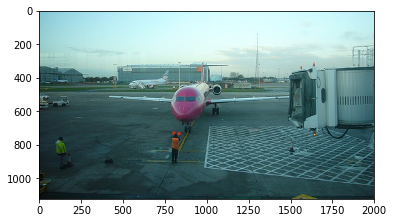

In [16]:
from matplotlib import pyplot as plt

x = train_images[0]
print('Input', x.shape)
x = x.astype('float32'). transpose((2, 0, 1)).expand_dims(axis = 0) / 255

conv_trans = nn.Conv2DTranspose(
    3, in_channels = 3, kernel_size = 8, padding = 2, strides = 4)
conv_trans.initialize()
conv_trans(x)
conv_trans.weight.set_data(bilinear_kernel(3, 3, 8))

y = conv_trans(x)
y = y[0].clip(0, 1).transpose((1, 2, 0))
print('Output', y.shape)

plt.imshow(y.asnumpy())
plt.show()

In [17]:
from mxnet import init

conv_trans = net[-1]
conv_trans.initialize(init = init.Zero())
net[-2].initialize(init = init.Xavier())

x = nd.zeros((batch_size, 3, *input_shape))
net(x)

shape = conv_trans.weight.data().shape
print(shape)
conv_trans.weight.set_data(bilinear_kernel(*shape[0:3]))

(21, 21, 64, 64)


In [18]:
import sys
sys.path.append('..')
import utils

loss = gluon.loss.SoftmaxCrossEntropyLoss(axis = 1)

ctx = utils.try_all_gpus()
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(), 
                        'sgd', {'learning_rate': .1, 'wd': 1e-2 })

utils.train(train_data, test_data, net, loss, 
            trainer, ctx, num_epochs = 30)

Start training on  [gpu(0)]
Epoch 0. Loss: 1.596, Train acc 0.72, Test acc 0.80, Time 61.5 sec
Epoch 1. Loss: 0.607, Train acc 0.82, Test acc 0.83, Time 29.3 sec
Epoch 2. Loss: 0.465, Train acc 0.86, Test acc 0.84, Time 29.2 sec
Epoch 3. Loss: 0.387, Train acc 0.88, Test acc 0.84, Time 29.1 sec
Epoch 4. Loss: 0.341, Train acc 0.89, Test acc 0.85, Time 29.2 sec
Epoch 5. Loss: 0.314, Train acc 0.90, Test acc 0.85, Time 29.3 sec
Epoch 6. Loss: 0.287, Train acc 0.91, Test acc 0.85, Time 29.1 sec
Epoch 7. Loss: 0.273, Train acc 0.91, Test acc 0.86, Time 29.3 sec
Epoch 8. Loss: 0.249, Train acc 0.92, Test acc 0.86, Time 29.1 sec
Epoch 9. Loss: 0.235, Train acc 0.92, Test acc 0.86, Time 29.5 sec
Epoch 10. Loss: 0.231, Train acc 0.92, Test acc 0.86, Time 28.9 sec
Epoch 11. Loss: 0.217, Train acc 0.93, Test acc 0.86, Time 29.1 sec
Epoch 12. Loss: 0.214, Train acc 0.93, Test acc 0.86, Time 29.1 sec
Epoch 13. Loss: 0.204, Train acc 0.93, Test acc 0.86, Time 29.4 sec
Epoch 14. Loss: 0.198, Train a

# Predict

In [19]:
def predict(im):
    data = normalize_image(im)
    data = data.transpose((2, 0, 1)).expand_dims(axis = 0)
    yhat = net(data.as_in_context(ctx[0]))
    pred = nd.argmax(yhat, axis = 1)
    # output format is batch_size x class_nums x height x width
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    x = pred.astype('int32').asnumpy()
    cm = np.array(colormap).astype('uint8')
    return nd.array(cm[x, :])

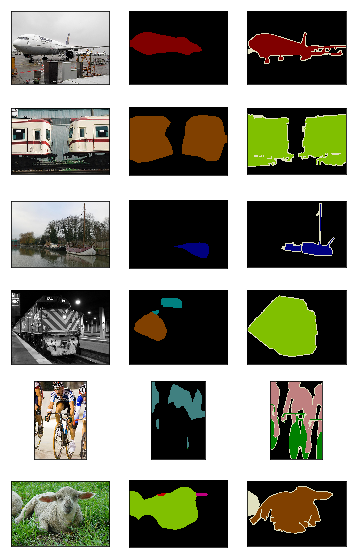

In [20]:
test_images, test_labels = read_images(train = False)

n = 6
imgs = []
for i in range(n):
    x = test_images[i]
    pred = label2image(predict(x))
    imgs += [x, pred, test_labels[i]]
    
utils.show_images(imgs, nrows = n, ncols = 3, figsize = (6, 10))